In [2]:
import random
import numpy as np
import matplotlib
import time
from numba import jit
import multiprocessing as mp
from matplotlib import pyplot as plt

In [3]:
@jit(nopython=True)
def demand(p1, p2):
    if p1 < p2:
        d = 1 - p1
    elif p1 == p2:
        d = 0.5 * (1 - p1)
    else:
        d = 0
    return d

In [4]:
@jit(nopython=True)
def profit(p1, p2):
    return (p1 * demand(p1, p2))

In [5]:
P = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 1]) # price array

In [6]:
@jit(nopython=True)
def best_response(p_jt, price_grid):
    best_response = 0
    max_profit = -1
    for p_it in price_grid:  # Iterer gennem en række mulige priser for p_it
        current_profit = profit(p_it, p_jt)
        if current_profit > max_profit:
            max_profit = current_profit
            best_response = p_it
    best_response_index = np.where(price_grid==best_response)[0][0]
    return best_response_index

In [7]:
@jit(nopython=True)
def FictitiousPlay(price_grid, period):
    # Q-tables and vectors
    Qtable_i = np.zeros((len(price_grid), len(price_grid)))
    Qtable_j = np.zeros((len(price_grid), len(price_grid)))
    Qtable_temp = np.zeros((len(price_grid), len(price_grid)))

    ProfitTable_i = np.zeros((len(price_grid), len(price_grid)))
    ProfitVector_i = np.zeros(len(price_grid))

    profit_1 = np.zeros(int(period))
    profit_2 = np.zeros(int(period))

    total_profit = np.zeros(period)

    # Period 1
    price_index_i = np.random.choice(len(price_grid)) 
    #print("t = 1")
    #print("price_index_i:", price_index_i)

    # Period 2
    price_index_j = best_response(price_grid[price_index_i], price_grid)
    opponent_actions = 1
    #print("t = 2")
    #print("price_index_j:", price_index_j)

    for t in range(3, period + 1):
        #print("t = ", t)
        # Current period
        Qtable_i[price_index_i, price_index_j] = Qtable_i[price_index_i, price_index_j] + 1
        #print("Qtable_i:", Qtable_i)

        for i in range(len(price_grid)):
            #print("opponent_actions:", opponent_actions)
            Qtable_i[price_index_i, i] = Qtable_i[price_index_i, i]/opponent_actions
            #print("Qtable_i efter division:", Qtable_i)
        
        for i in range(len(price_grid)):
            for j in range(len(price_grid)):
                #print("profit(price_grid[i], price_grid[j])", profit(price_grid[i], price_grid[j]))
                #print("Qtable_i[i, j]", Qtable_i[i, j])
                ProfitTable_i[i, j] = profit(price_grid[i], price_grid[j])*Qtable_i[i, j]
            ProfitVector_i[i] = np.sum(ProfitTable_i[i, :])
            #print("ProfitVector_i:", ProfitVector_i)

        if np.all(ProfitVector_i == 0):
            price_index_i = np.random.choice(len(price_grid)) 
        else:
            price_index_i = np.argmax(ProfitVector_i)
        #print("price_index_i:", price_index_i)

        profit_opponent = profit(price_grid[price_index_j], price_grid[price_index_i])
        profit_i_current_period = profit(price_grid[price_index_i], price_grid[price_index_j])

        # Profit
        total_profit[t-1] = (profit_i_current_period + profit_opponent) / 2

        # Update for the next iteration: Use the simulated next period's action as the actual action for the opponent
        if t % 2 == 0:
            profit_1[t-1] = profit_opponent
            profit_2[t-1] = profit_i_current_period
        else:
            profit_1[t-1] = profit_i_current_period
            profit_2[t-1] = profit_opponent
            opponent_actions += 1

        # Switch player for next period
        Qtable_temp = Qtable_j
        Qtable_j = Qtable_i
        Qtable_i = Qtable_temp
        price_index_temp = price_index_j
        price_index_j = price_index_i
        price_index_i = price_index_temp
    
    return total_profit, profit_1, profit_2

In [8]:
@jit(nopython=True)
def Simulations(sim, price_grid, period):
    total_profit_sim = np.zeros((sim, period))
    profit_1_sim = np.zeros((sim, period))
    profit_2_sim = np.zeros((sim, period))
    avg_profit = np.zeros(sim)
    avg_profit_1 = np.zeros(sim)
    avg_profit_2 = np.zeros(sim)

    for i in range(sim):
        total_profit_array, profit_1_array, profit_2_array = FictitiousPlay(price_grid, period)
        total_profit_sim[i] = total_profit_array
        profit_1_sim[i] = profit_1_array
        profit_2_sim[i] = profit_2_array
        avg_profit_1[i] = np.mean(profit_1_array[-1000:])
        avg_profit_2[i] = np.mean(profit_2_array[-1000:])

    return total_profit_sim, avg_profit_1, avg_profit_2, profit_1_sim, profit_2_sim

In [9]:
start_time  = time.time()

total_profit_plot, avg_profit_1_plot, avg_profit_2_plot, profit_total_1, profit_total_2 = Simulations(1000, P, 500000)

end_time = time.time()

elapsed_time = end_time - start_time

print("Time taken to run 1000 simulations:", elapsed_time, "seconds")

Time taken to run 1000 simulations: 51.527573108673096 seconds


In [10]:
samlet_prof = total_profit_plot.mean(0)
window_size = 1000
  
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
# Loop through the array t o
#consider every window of size 1000
while i < len(samlet_prof) - window_size + 1:
  
    # Calculate the average of current window
    window_average = np.sum(samlet_prof[i:i+window_size]) / window_size
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1

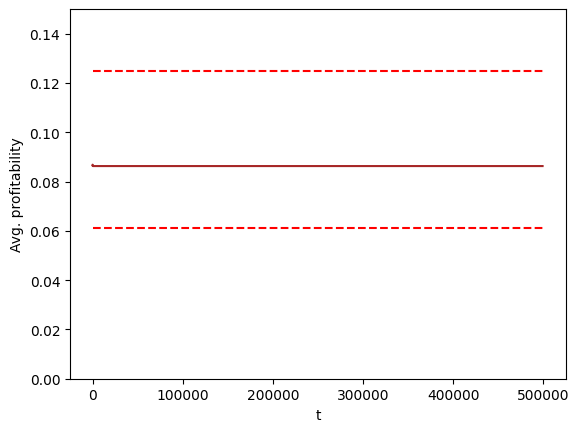

In [11]:
plt.plot(moving_averages, color='#a62626', label="Average profitability")
plt.xlabel('t')
plt.ylabel('Avg. profitability')
plt.ylim(0.00, 0.15)
plt.hlines(y=0.0611, xmin=0, xmax=500000, colors='red', linestyles='--')
plt.hlines(y=0.125, xmin=0, xmax=500000, colors='red', linestyles='--')
plt.show()